In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as signal
import IPython.display as IPD
import seaborn as sns
import librosa
import librosa.display
import make_pseudo_label
import config
import noise
matplotlib.rcParams['figure.figsize'] = (16, 10)

/home/iwai/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [607]:
cv_res = []
for i  in range(5):
    res = pd.read_csv("cv/VGG1Dv2/2018_01_04_13_57_11_VGG1Dv2_2017_online/fold_{}_test.csv".format(i))
    cv_res.append(res)

/home/iwai/Documents/workspace/kaggle/speech-recognition/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [608]:
res = pd.read_csv("model/VGG1Dv2/2018_01_09_02_15_56/valid_probs.csv")

In [609]:
miss = res[res.plnum != np.argmax(res.iloc[:, -12:].values, axis=1)]

In [610]:
miss.index = range(len(miss))
predict = pd.Series(miss.iloc[:, -12:].idxmax(axis=1), name="predict")
predict_max_probs = pd.Series(np.max(miss.iloc[:, -12:], axis=1), name="max_prob")
miss = pd.concat([miss, predict, predict_max_probs], axis=1, )
prob_sorted = miss.sort_values(by="max_prob")

In [611]:
pd.crosstab(miss.possible_label, miss.predict)

predict         down  go  left  no  off  on  right  silence  stop  unknown  up
possible_label                                                                
down               0   1     0   4    0   0      0        0     0        1   0
go                 2   0     0   4    0   1      0        4     0        2   1
left               0   0     0   2    0   0      0        0     0        0   0
no                 1   6     0   0    0   0      0        0     0        1   0
off                0   1     0   0    0   0      0        0     1        0  16
on                 0   0     0   0    4   0      0        4     0        3   0
right              0   1     2   0    0   0      0        0     0        6   0
stop               0   0     0   0    0   0      0        2     0        4   2
unknown            1   2     1   0    0   0      0        3     1        0   2
up                 0   0     0   0    1   1      0        2     0        3   0
yes                1   0     4   1    0   1      1        2     0        2   0

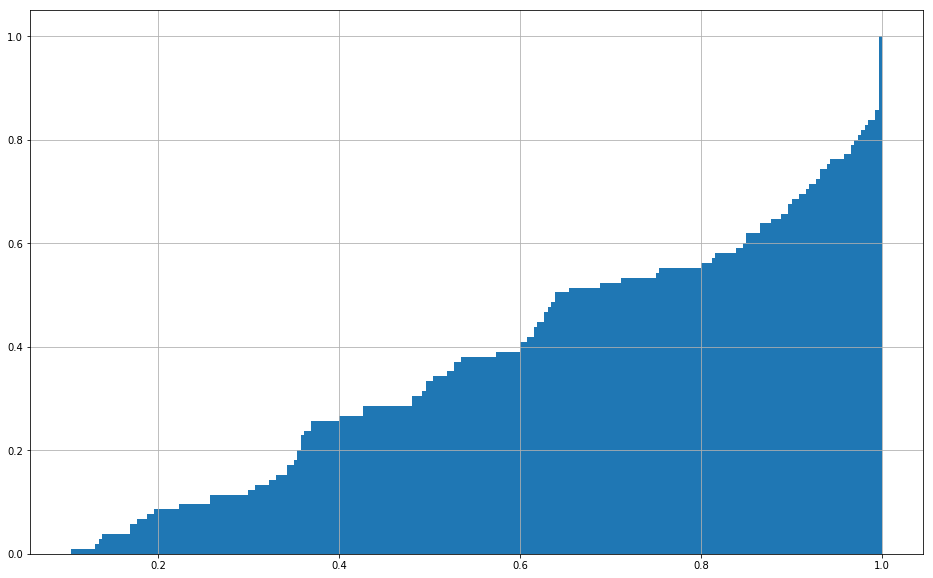

In [303]:
prob_sorted.max_prob.hist(cumulative=True, normed=1, bins=233)

In [304]:
def show_sample(row):
    sr, wav = wavfile.read(row.path)
    print("fname: {}\tlabel: {}\tpredict: {}\tprobs: {}".format(row.path, row.possible_label, row.predict, row.max_prob))
    IPD.display(IPD.Audio(wav, rate=sr))

print(len(prob_sorted[prob_sorted.possible_label == "unknown"].head(20).apply(show_sample, axis=1)))

fname: input/train/audio/cat/1bc45db9_nohash_0.wav	label: unknown	predict: silence	probs: 0.1794019341468811


fname: input/train/audio/four/d197e3ae_nohash_4.wav	label: unknown	predict: silence	probs: 0.3575699031352997


fname: input/train/audio/one/d197e3ae_nohash_4.wav	label: unknown	predict: silence	probs: 0.35972273349761963


fname: input/train/audio/nine/c6ee87a7_nohash_3.wav	label: unknown	predict: left	probs: 0.3703188002109528


fname: input/train/audio/one/6c0f6493_nohash_2.wav	label: unknown	predict: up	probs: 0.6403347253799438


fname: input/train/audio/bed/cab100c9_nohash_0.wav	label: unknown	predict: go	probs: 0.8497702479362488


fname: input/train/audio/house/88f8a99c_nohash_0.wav	label: unknown	predict: up	probs: 0.8964247107505798


fname: input/train/audio/four/7c1d8533_nohash_2.wav	label: unknown	predict: go	probs: 0.9229667186737059


fname: input/train/audio/dog/364c0853_nohash_0.wav	label: unknown	predict: down	probs: 0.9308062195777892


fname: input/train/audio/cat/67c7fecb_nohash_0.wav	label: unknown	predict: stop	probs: 0.9968718886375428


10


In [237]:
sr, wav = wavfile.read('data/augment/2017_12_28_20_04_03/speed_up/four/28ce0c58_nohash_4.wav'.format(i))
IPD.display(IPD.Audio(wav, rate=sr))

In [177]:
np.abs(wav).max()*0.1

997.70000000000005

In [239]:
sr, wav = wavfile.read('input/train/audio/three/1a9afd33_nohash_0.wav')
IPD.display(IPD.Audio(wav, rate=sr))

In [48]:
stft_submit = pd.read_csv("submit/2018_01_02_13_39_20.csv")
vgg1d_submit = pd.read_csv("submit/2018_01_01_20_16_18.csv")

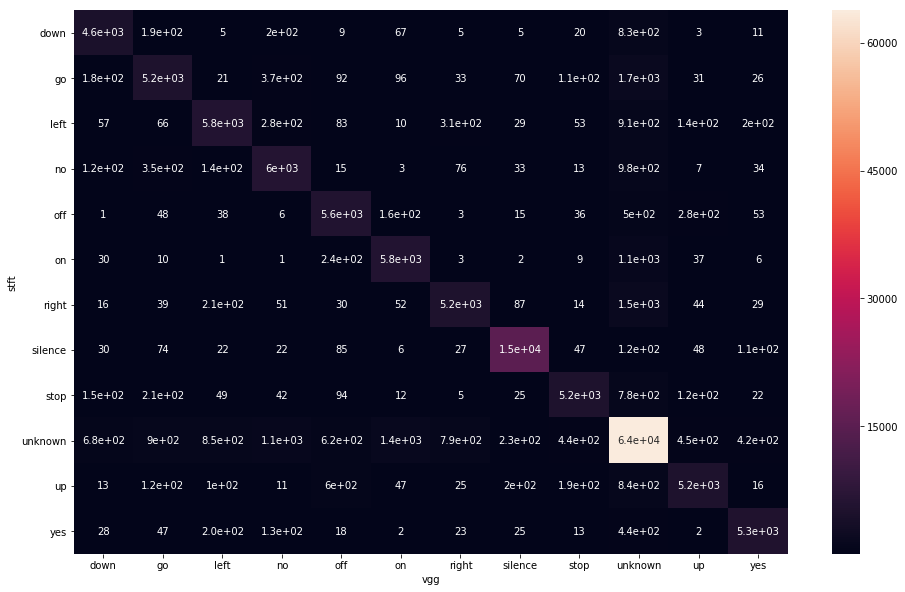

In [63]:
stft = stft_submit.rename(columns={"label": "stft"})
vgg = vgg1d_submit.rename(columns={"label": "vgg"})
sns.heatmap(pd.crosstab(stft.stft, vgg.vgg), annot=True)

In [80]:
for fname, l in vgg1d_submit[vgg1d_submit.label != stft_submit.label].sample(5).values:
    print(fname, l)
    sr, wav = wavfile.read('input/test/audio/{}'.format(fname))
    IPD.display(IPD.Audio(wav, rate=sr))

clip_a3ce5efc9.wav off


clip_4e520ad8d.wav unknown


clip_509bd6a87.wav no


clip_ee04cea92.wav off


clip_02ce383fd.wav unknown


In [82]:
sr, wav = wavfile.read('input/test/audio/clip_3747da4c8.wav')
IPD.display(IPD.Audio(wav, rate=sr))

In [15]:
cv_stft = []
for i in range(5):
    X = make_pseudo_label.make_pseudo_labeling("STFTCNN/2018_01_07_05_16_53/", i, max_probs_drop=False)
    cv_stft.append(X)

fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    75437
silence    14393
on          8018
off         7485
go          7383
no          7149
left        6916
right       6725
stop        6586
up          6428
yes         6089
down        5929
Name: possible_label, dtype: int64
fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    75146
silence    14088
on          7972
go          7593
off         7430
no          7148
left        7106
right       7011
stop        6632
up          6391
yes         6102
down        5919
Name: possible_label, dtype: int64
fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    76060
silence    14415
on          7853
off         7331
go          7280
right       7030
no          6962
left        6958
up          6449
stop        6281
yes         6137
down        5782
Name: possible_label, dtype: int64
fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    76020
silence    12547
go          7950
on          7767
off        

vgg1dv2 fold 0


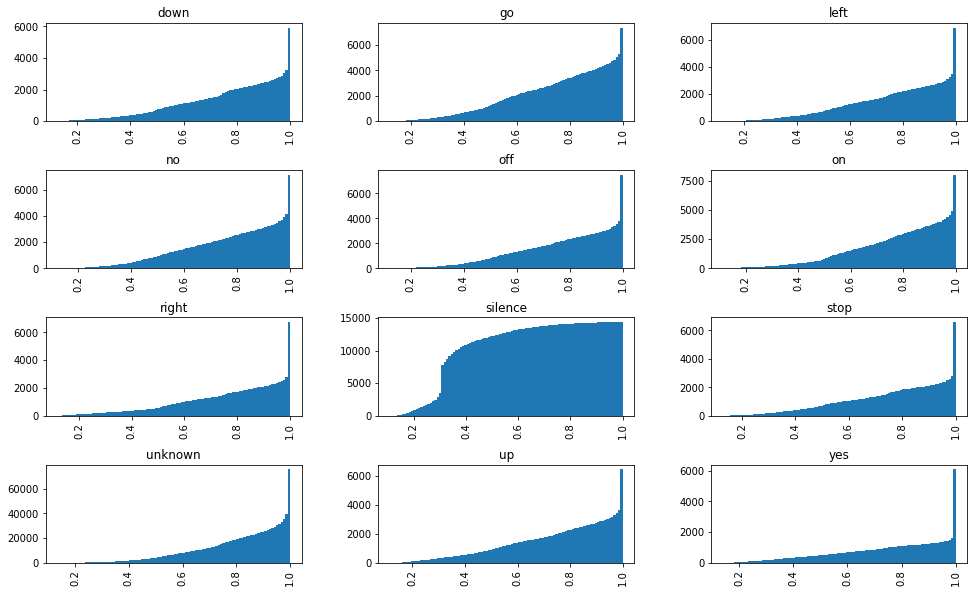

vgg1dv2 fold 1


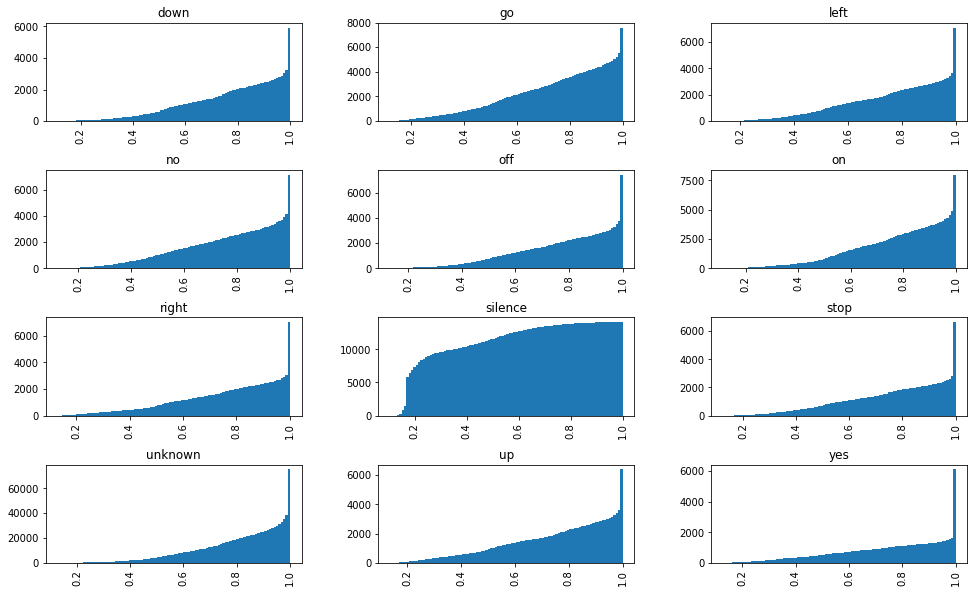

vgg1dv2 fold 2


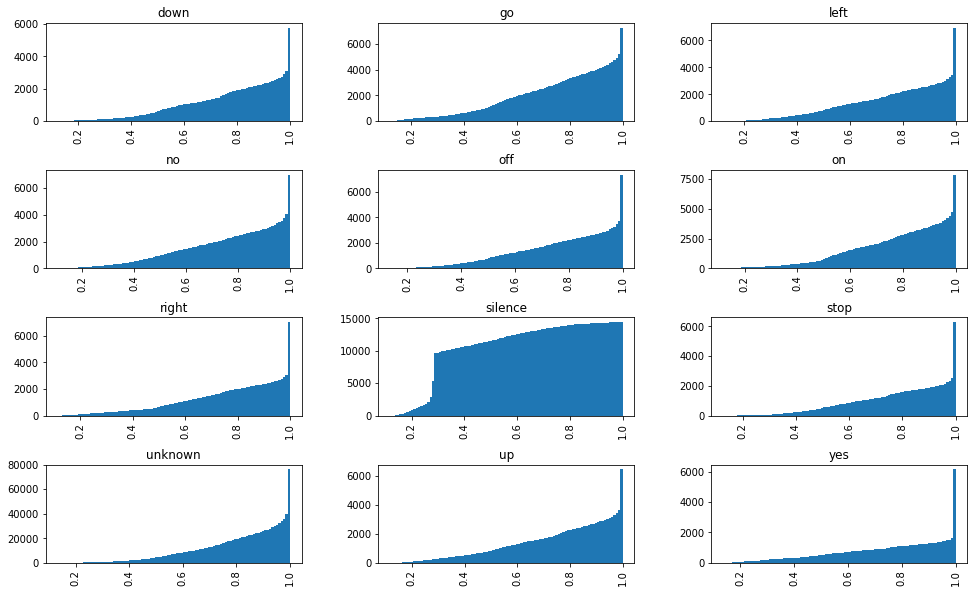

vgg1dv2 fold 3


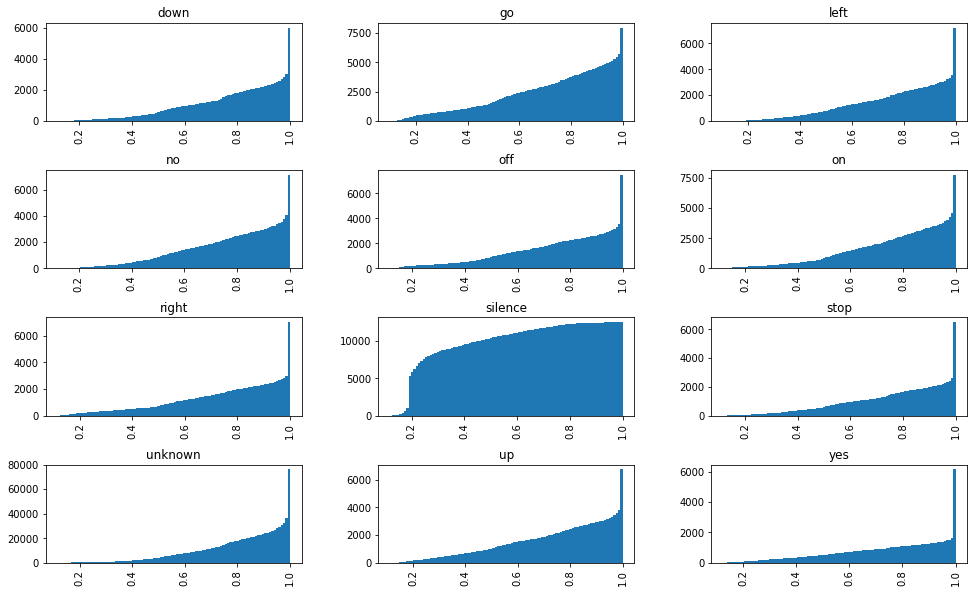

vgg1dv2 fold 4


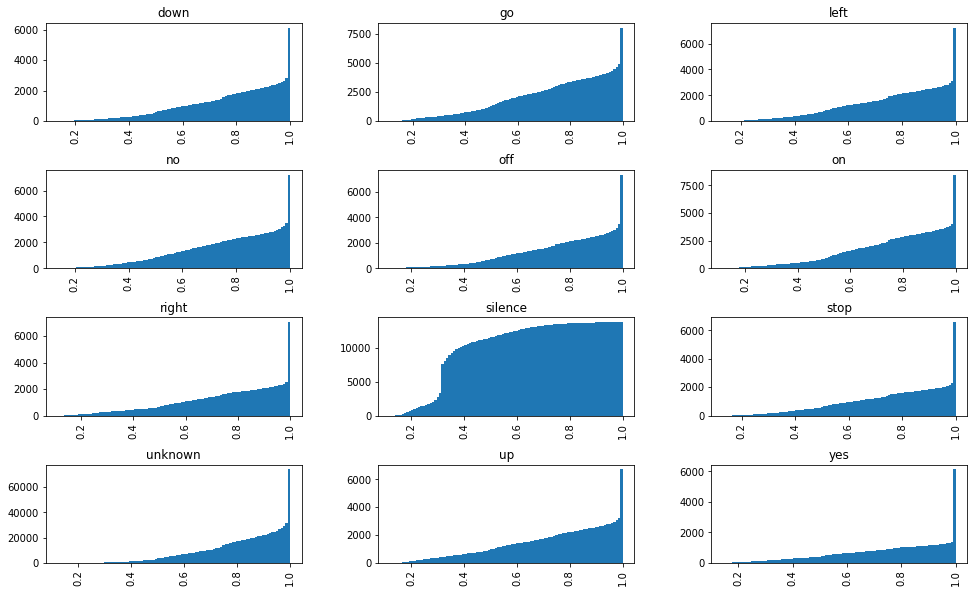

In [17]:
for i, X in enumerate(cv_stft):
    print("stftcnn fold", i)
    X["max_probs"].hist(by=X["possible_label"], cumulative=True, bins=100)
    plt.show()

In [181]:
cv_vgg1d = []
for i in range(5):
    X2 = make_pseudo_label.make_pseudo_labeling("VGG1Dv2/2018_01_10_22_50_50_VGG1Dv2_3018_online_2018_01_11_09_26_40", i, max_probs_drop=False)
    cv_vgg1d.append(X2)

fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    76454
silence    15367
left        8031
no          7442
on          7104
go          6949
off         6803
up          6689
right       6100
down        5907
stop        5860
yes         5832
Name: possible_label, dtype: int64
fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    77141
silence    15496
left        7788
no          7389
on          6900
go          6882
off         6718
up          6567
right       6101
stop        5965
yes         5818
down        5773
Name: possible_label, dtype: int64
fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    76402
silence    15440
left        7800
no          7372
go          7355
on          7077
off         6642
up          6599
right       6287
stop        6013
down        5845
yes         5706
Name: possible_label, dtype: int64
fold 0
fold 1
fold 2
fold 3
fold 4
(4, 158538, 12)
unknown    77036
silence    15627
left        7753
no          7447
go         

vgg1dv2 fold 0


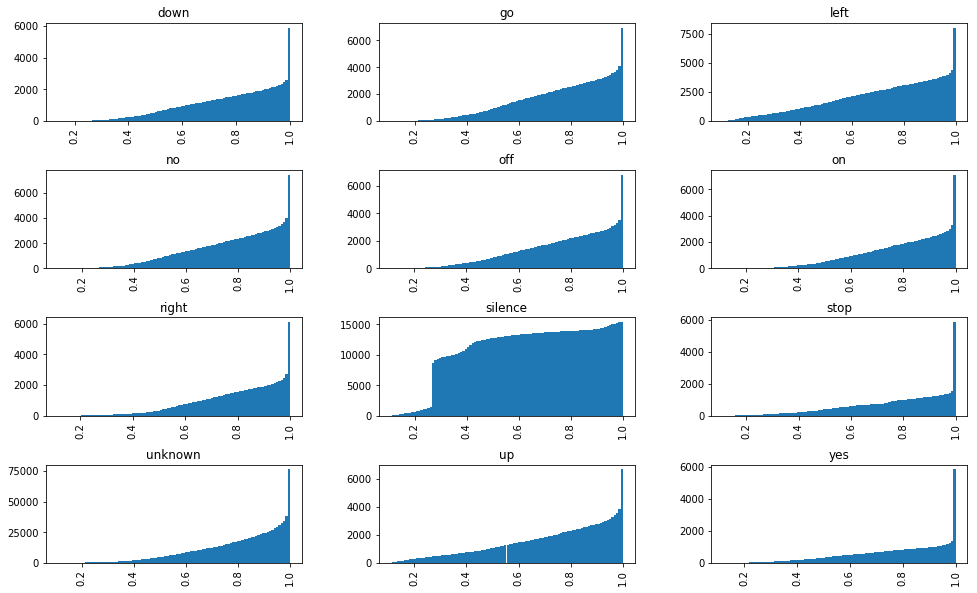

vgg1dv2 fold 1


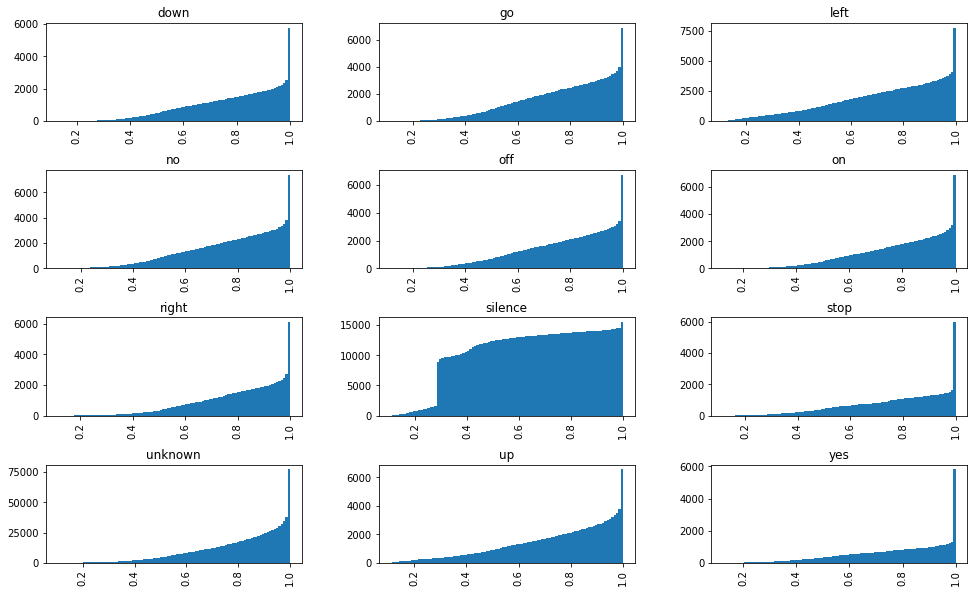

vgg1dv2 fold 2


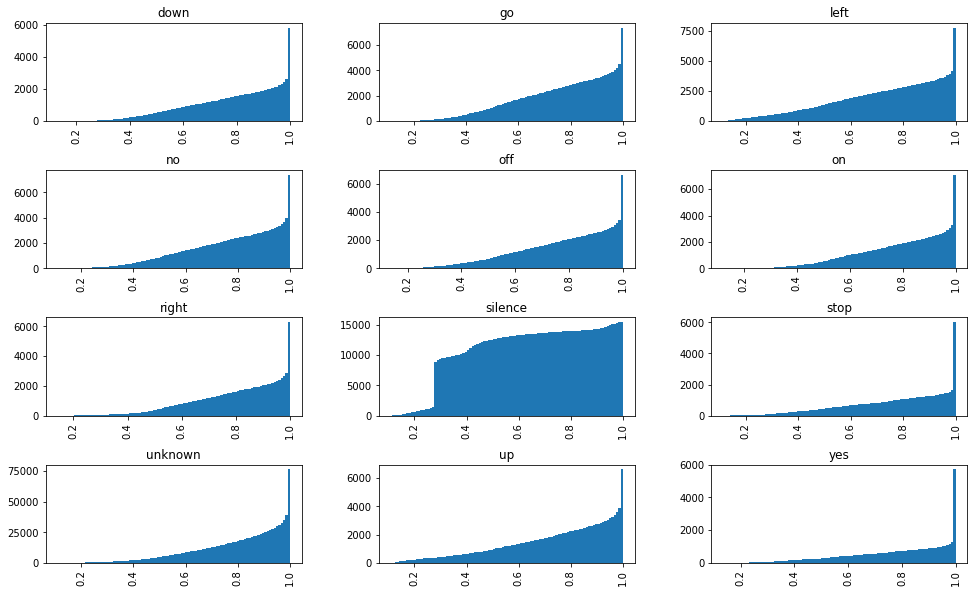

vgg1dv2 fold 3


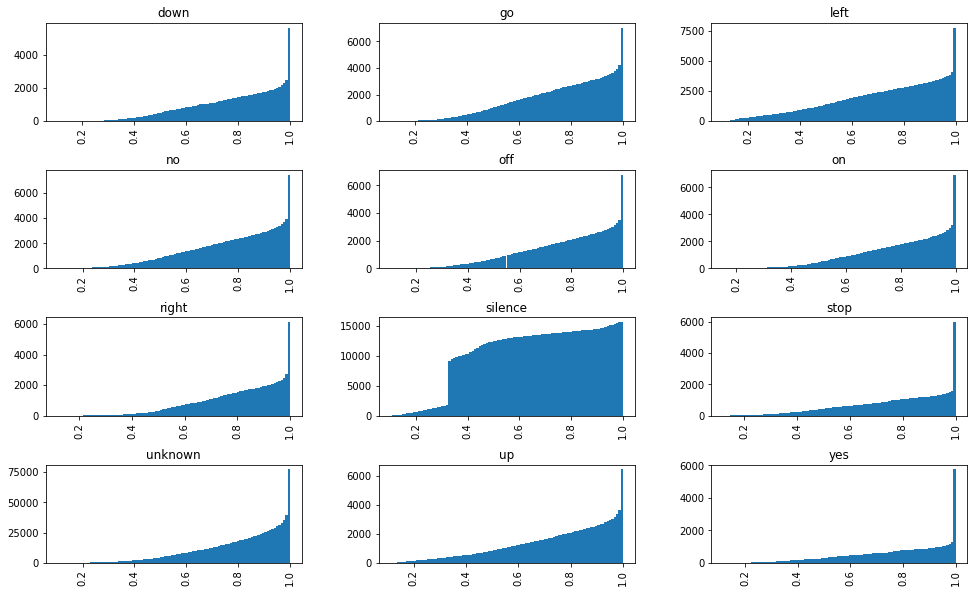

vgg1dv2 fold 4


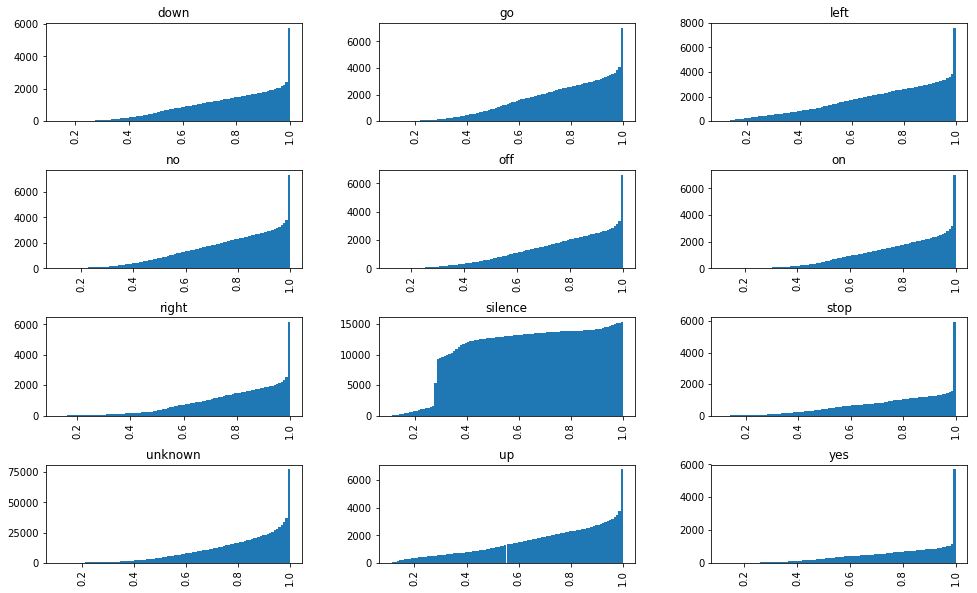

In [182]:
for i, X in enumerate(cv_vgg1d):
    print("vgg1dv2 fold", i)
    X["max_probs"].hist(by=X["possible_label"], cumulative=True, bins=100)
    plt.show()

In [190]:
for fname in cv_vgg1d[0][cv_vgg1d[0].possible_label == "off"].sample(5)[["path", "max_probs"]].values:
    print(fname[0], fname[1])
    sr, wav = wavfile.read(str(fname[0]))
    IPD.display(IPD.Audio(wav, rate=sr))

input/test/audio/clip_a1238c98e.wav 0.7426291108131409


input/test/audio/clip_57812b865.wav 0.9994654208421707


input/test/audio/clip_9c84311b8.wav 0.9997915178537369


input/test/audio/clip_9766741b4.wav 0.8673523664474487


input/test/audio/clip_152245667.wav 0.6161597073078156


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd580864d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd4e9741390>]], dtype=object)

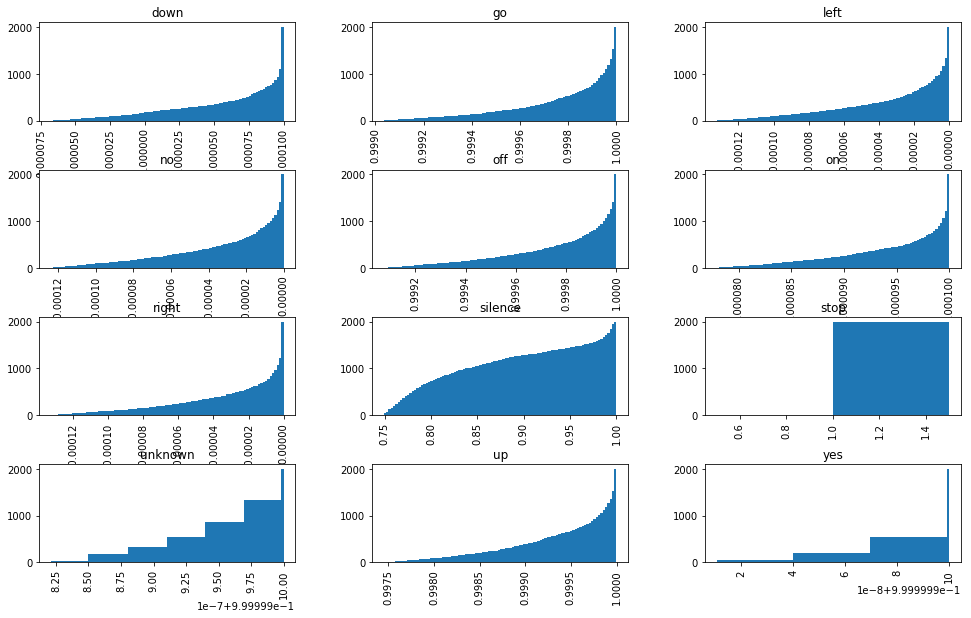

In [49]:
def pseudo_sampling(label):
    return label.sort_values(by="max_probs", ascending=False)[:2000]

cv_vgg1d[0].groupby("possible_label").apply(pseudo_sampling)["max_probs"].hist(by="possible_label", cumulative=True, bins=100)

In [767]:
vgg_sub = pd.read_csv("submit/2018_01_13_12_47_26.csv")
vgg_sub = vgg_sub.sort_values(by="fname").reset_index(drop=True)
vgg_sub = vgg_sub.rename(columns={"label": "vgg"})
stft_sub = pd.read_csv("submit/2018_01_15_12_18_53.csv")
stft_sub = stft_sub.sort_values(by="fname").reset_index(drop=True)
stft_sub = stft_sub.rename(columns={"label": "stft"})
assert(all(vgg_sub.fname.values == stft_sub.fname.values))

In [768]:
pd.crosstab(vgg_sub.vgg, stft_sub.stft)

stft     down    go  left    no   off    on  right  silence  stop  unknown  \
vgg                                                                          
down     5397    22     0    25     0     9      0        8     0       51   
go          9  6337     1    30     8     3      1       13     6      141   
left        1     0  6562    16     2     0     10        6     1      155   
no         10    38    13  6643     0     0      0        8     2       70   
off         0     0     1     0  6368    18      0        2     5       77   
on          0     3     0     0    20  6618      3        6     0      157   
right       0     0    27     3     0     0   5747        3     1       93   
silence     0     1     4     0     4     3      0    15480     1       26   
stop       21    12     2     2     7     0      0       10  5830       65   
unknown    55    57    50    63    39    95     62       33    16    79797   
up          0    12     1     2    38     1      2       43    12       65   
yes         1     1    19     1     0     0      0        6     0       47   

stft       up   yes  
vgg                  
down        0     0  
go          6     0  
left       18     8  
no          1     6  
off        64     0  
on          1     0  
right       1     0  
silence     4     0  
stop       13     0  
unknown    47     5  
up       6047     0  
yes         0  5581

In [769]:
stft_sub.stft.value_counts(normalize=False)

unknown    80744
silence    15618
no          6785
on          6747
left        6680
off         6486
go          6483
up          6202
stop        5874
right       5825
yes         5600
down        5494
Name: stft, dtype: int64

In [770]:
sub_probs = pd.read_csv("result/probs/2018_01_15_12_18_53.csv")
sub_probs["max_probs"] = sub_probs[config.POSSIBLE_LABELS].max(1)
sub_probs["second_probs"] = np.sort(sub_probs[config.POSSIBLE_LABELS])[:, -2]
sub_probs["label"] = sub_probs[config.POSSIBLE_LABELS].idxmax(1)

In [718]:
arank = sub_probs[config.POSSIBLE_LABELS].apply(np.argsort, axis=1)
sub_probs["second_label"] = sub_probs[config.POSSIBLE_LABELS].columns.to_series()[arank.values[:,::-1][:,2]].reset_index(drop=True)

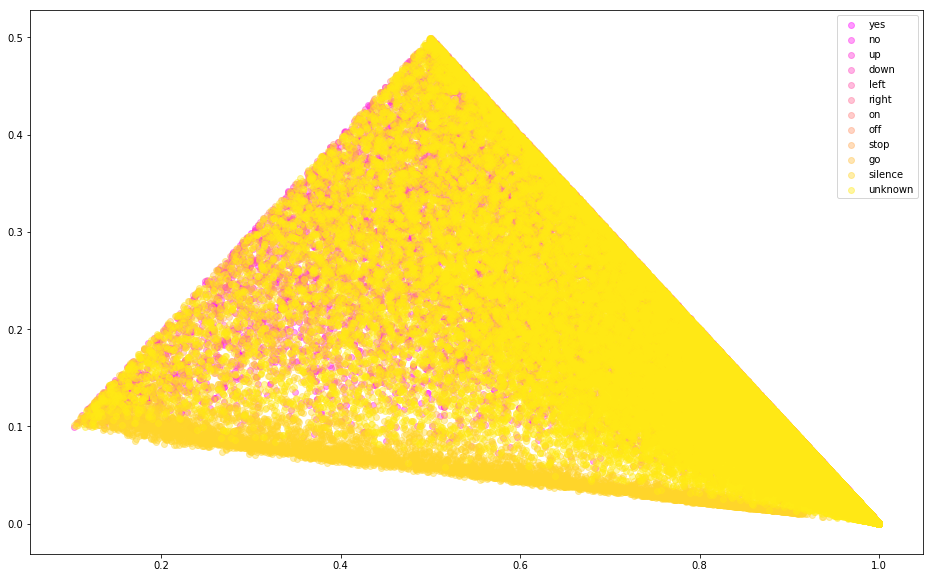

In [614]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cmap = plt.get_cmap("spring")

for i, l in enumerate(config.POSSIBLE_LABELS):
    ax.scatter(sub_probs[sub_probs.label == l].max_probs, 
                       sub_probs[sub_probs.label == l].second_probs, 
                       c=cmap(i/12), 
                       label=l,
                       alpha=0.4)

plt.legend()
plt.show()

In [650]:
len(sub_probs[(sub_probs.max_probs < 0.2) & (sub_probs.second_probs < 0.2)])

1368

In [631]:
for row in sub_probs[(sub_probs.max_probs < 0.15) & (sub_probs.second_probs < 0.2) & (~sub_probs.label.isin(["silence", "unknown"])) & (~sub_probs.second_label.isin(["silence", "unknown"]))][["fname", "label", "max_probs", "second_label", "second_probs"]].sample(5).values:
    print(row)
    sr, wav = wavfile.read('input/test/audio/' + row[0])
    rms = np.sqrt(np.mean(np.square(wav)))
    print("rms", rms)
    IPD.display(IPD.Audio(wav, rate=sr))

['clip_77d5fe4a3.wav' 'on' 0.1331271943843199 'up' 0.12595843250552813]
rms 57.0250701446


['clip_5d90588a4.wav' 'up' 0.12678344634672006 'stop' 0.1225579710974772]
rms 49.297537971


['clip_18e84303a.wav' 'go' 0.1249438943548335 'right' 0.11940743970788187]
rms 26.8719254055


['clip_454c379ec.wav' 'up' 0.13621905305319362 'go' 0.12555740041271848]
rms 34.5797800383


['clip_cb98c664f.wav' 'up' 0.12412239602870412 'go' 0.10753423070742024]
rms 27.3819911164


In [642]:
def loudness(fname):
    sr, wav = wavfile.read('input/test/audio/' + fname)
    rms = np.sqrt(np.mean(np.square(wav)))
    return rms

sub_probs["rms"] = sub_probs.fname.apply(loudness)

In [643]:
sub_probs.rms.head()

0    59.090804
1    35.541107
2    37.012087
3    57.356307
4    28.841894
Name: rms, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bcad8ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bbc3aef0>]], dtype=object)

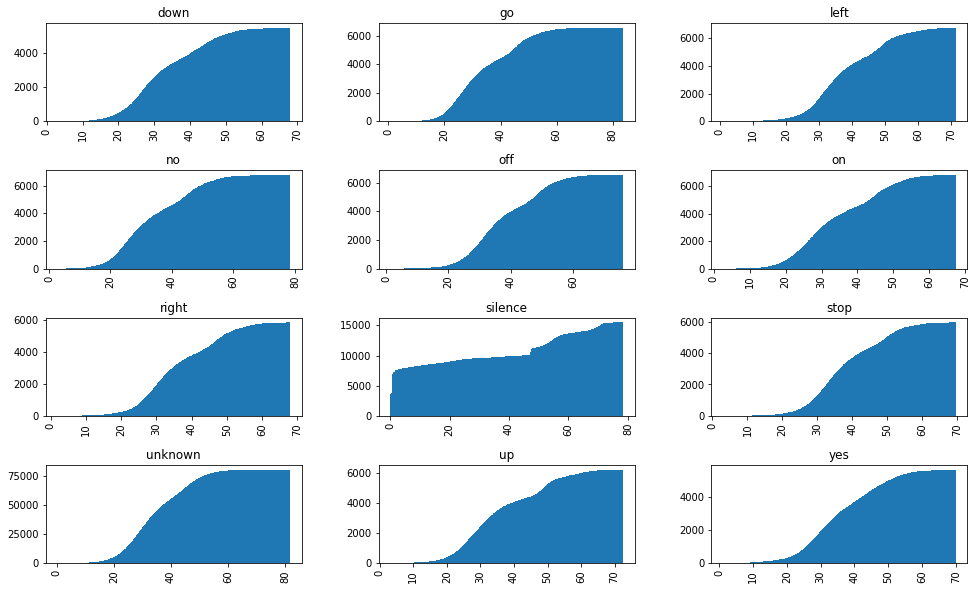

In [647]:
sub_probs["rms"].hist(by=sub_probs["label"], cumulative=True, bins=1000)

In [750]:
sub_probs.label.value_counts(normalize=False)

unknown    81489
silence    15527
left        6656
no          6552
go          6552
on          6468
up          6371
off         6287
right       5823
stop        5805
yes         5560
down        5448
Name: label, dtype: int64

In [543]:
sub_probs.second_probs.head()

0    3.764778e-04
1    1.258863e-04
2    7.809791e-02
3    4.139619e-02
4    9.203918e-07
Name: second_probs, dtype: float64

In [775]:
for fname in sub_probs[(sub_probs.label == "on")].sample(5)[["fname", "max_probs"]].values:
    print(fname[0], fname[1])
    sr, wav = wavfile.read('input/test/audio/' + fname[0])
    IPD.display(IPD.Audio(wav, rate=sr))

clip_98699e519.wav 0.936654187904464


clip_d76d8ec52.wav 0.39437904718797656


clip_9f0e22d02.wav 0.9999842166900637


clip_e2096ea33.wav 0.7755494868048118


clip_1ae4c0e56.wav 0.7965879737360106


In [393]:
160000 * 0.03683

5892.8

In [533]:
len(sub_probs[(sub_probs.max_probs <=0.5) & (sub_probs.label == "on")])

466

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4b85b0828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bb31ca58>]], dtype=object)

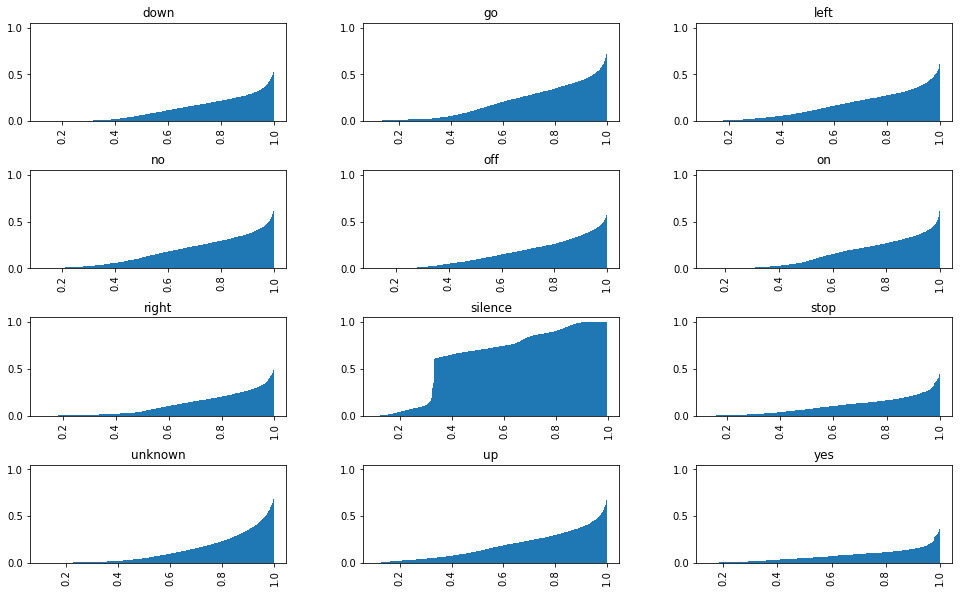

In [410]:
sub_probs["max_probs"].hist(by=sub_probs["label"], bins=1000, normed=True, cumulative=True)

label
down       AxesSubplot(0.125,0.125;0.775x0.755)
go         AxesSubplot(0.125,0.125;0.775x0.755)
left       AxesSubplot(0.125,0.125;0.775x0.755)
no         AxesSubplot(0.125,0.125;0.775x0.755)
off        AxesSubplot(0.125,0.125;0.775x0.755)
on         AxesSubplot(0.125,0.125;0.775x0.755)
right      AxesSubplot(0.125,0.125;0.775x0.755)
silence    AxesSubplot(0.125,0.125;0.775x0.755)
stop       AxesSubplot(0.125,0.125;0.775x0.755)
unknown    AxesSubplot(0.125,0.125;0.775x0.755)
up         AxesSubplot(0.125,0.125;0.775x0.755)
yes        AxesSubplot(0.125,0.125;0.775x0.755)
Name: max_probs, dtype: object

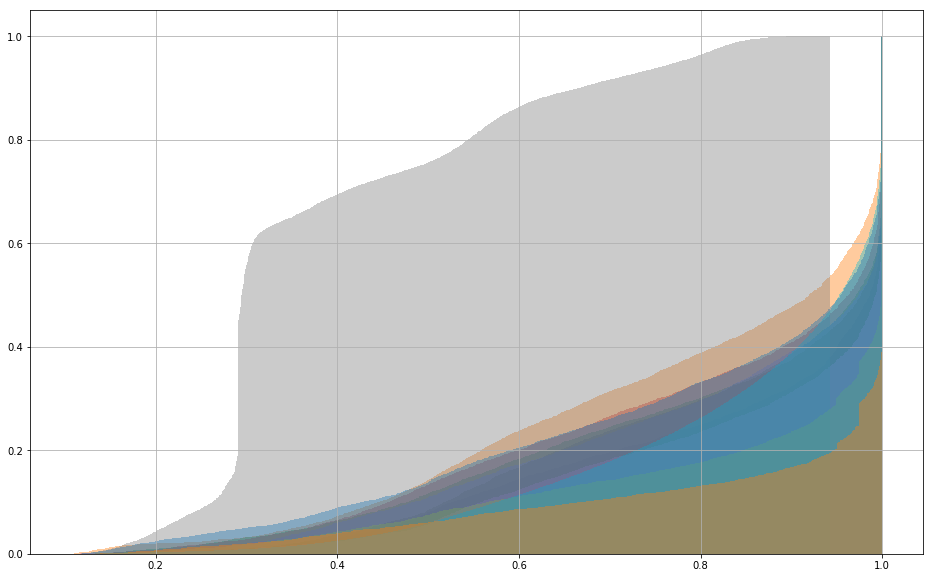

In [239]:
fig, ax = plt.subplots()
sub_probs.groupby("label").max_probs.hist(cumulative=True, bins=1000, normed=True, ax=ax, alpha=0.4)

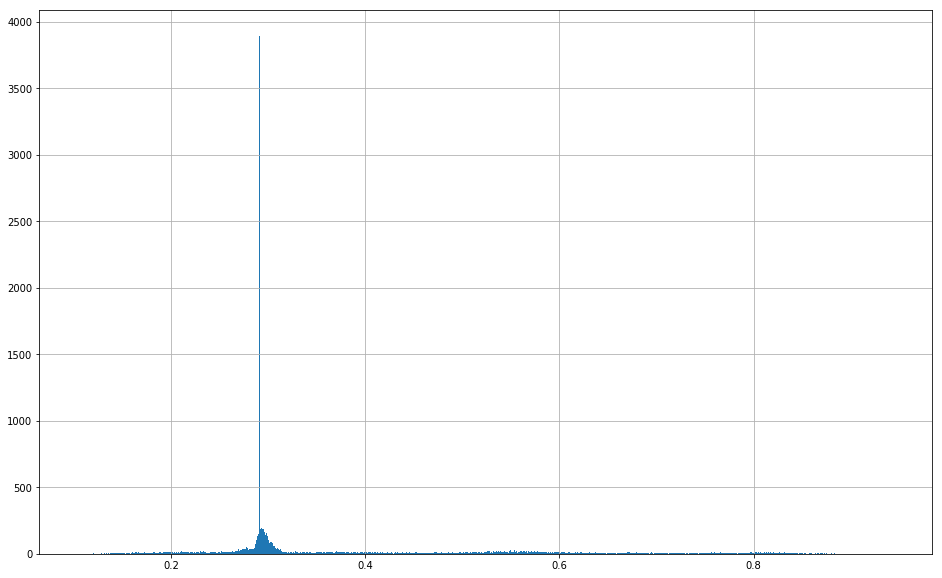

In [243]:
sub_probs[sub_probs.label == "silence"]["max_probs"].hist(bins=1000)

In [258]:
for fname in sub_probs[sub_probs.label == "on"].sample(5).values:
    print(fname[0], fname[-2])
    sr, wav = wavfile.read('input/test/audio/' + fname[0])
    IPD.display(IPD.Audio(wav, rate=sr))

clip_1879fc46a.wav 0.9733060076832772


clip_040c88d81.wav 0.5954228553455323


clip_710c27bcd.wav 0.4789804801810533


clip_3f92a5098.wav 0.7688435066491366


clip_a52fdecc6.wav 0.6270101131405681


In [107]:
len(vgg_sub)

158538

In [123]:
for fname in vgg_sub[vgg_sub.vgg == "on"].sample(5).values:
    print(fname[0], fname[1])
    sr, wav = wavfile.read('input/test/audio/' + fname[0])
    IPD.display(IPD.Audio(wav, rate=sr))

clip_52f0e0939.wav on


clip_1b5cd1f71.wav on


clip_777f9cf36.wav on


clip_f2d4c7cb2.wav on


clip_513e69b47.wav on


In [50]:
X.columns

Index(['path', 'plnum', 'possible_label'], dtype='object')

In [3]:
make_pserudo_label.make_pseudo_augment(X, config.AUG_LIST, "2018_01_02_22_20_44_test_augment")

path  plnum  \
2                     input/test/audio/clip_df571e207.wav      0   
3                     input/test/audio/clip_f3a6a5c5f.wav     11   
4                     input/test/audio/clip_c5b65522e.wav     10   
5                     input/test/audio/clip_469eaef8e.wav     11   
9                     input/test/audio/clip_4981a2c9d.wav     11   
14                    input/test/audio/clip_31ee29b76.wav      1   
16                    input/test/audio/clip_8ace15dd4.wav      7   
17                    input/test/audio/clip_814af1229.wav     11   
19                    input/test/audio/clip_8853ae0e2.wav      0   
21                    input/test/audio/clip_380bde467.wav      7   
24                    input/test/audio/clip_3edb98dee.wav     11   
26                    input/test/audio/clip_e5bdd5370.wav     11   
27                    input/test/audio/clip_73e8bb94e.wav      9   
28                    input/test/audio/clip_115b40c44.wav      1   
30                    input/test/audio/clip_c0fe96121.wav      1   
33                    input/test/audio/clip_4000a6851.wav     11   
38                    input/test/audio/clip_545a1ae73.wav      1   
41                    input/test/audio/clip_b319fbf76.wav      8   
42                    input/test/audio/clip_79f735920.wav      3   
43                    input/test/audio/clip_f5a9e7e41.wav      1   
44                    input/test/audio/clip_3726e72cb.wav     11   
45                    input/test/audio/clip_e58997880.wav     11   
46                    input/test/audio/clip_8f2e55e7e.wav      0   
49                    input/test/audio/clip_a4114a8e4.wav      0   
51                    input/test/audio/clip_344d56ec2.wav      8   
57                    input/test/audio/clip_3b9bebdb2.wav      7   
59                    input/test/audio/clip_3c9903b15.wav     11   
61                    input/test/audio/clip_9f2da4477.wav     11   
62                    input/test/audio/clip_c421a9af8.wav      5   
64                    input/test/audio/clip_1e5649b86.wav     11   
...                                                   ...    ...   
158466  data/augment/2018_01_02_22_20_44_test_augment/...      4   
158468  data/augment/2018_01_02_22_20_44_test_augment/...      1   
158469  data/augment/2018_01_02_22_20_44_test_augment/...      4   
158475  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158482  data/augment/2018_01_02_22_20_44_test_augment/...      0   
158486  data/augment/2018_01_02_22_20_44_test_augment/...      2   
158488  data/augment/2018_01_02_22_20_44_test_augment/...      2   
158492  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158499  data/augment/2018_01_02_22_20_44_test_augment/...      1   
158500  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158501  data/augment/2018_01_02_22_20_44_test_augment/...      1   
158503  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158504  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158505  data/augment/2018_01_02_22_20_44_test_augment/...      8   
158507  data/augment/2018_01_02_22_20_44_test_augment/...      0   
158508  data/augment/2018_01_02_22_20_44_test_augment/...      8   
158509  data/augment/2018_01_02_22_20_44_test_augment/...      6   
158510  data/augment/2018_01_02_22_20_44_test_augment/...      7   
158511  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158513  data/augment/2018_01_02_22_20_44_test_augment/...      6   
158514  data/augment/2018_01_02_22_20_44_test_augment/...      0   
158515  data/augment/2018_01_02_22_20_44_test_augment/...     10   
158516  data/augment/2018_01_02_22_20_44_test_augment/...      0   
158519  data/augment/2018_01_02_22_20_44_test_augment/...      9   
158520  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158521  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158524  data/augment/2018_01_02_22_20_44_test_augment/...     11   
158527  data/augment/2018_01_02_22_20_44_

In [5]:
%debug

> /home/iwai/Documents/workspace/kaggle/speech-recognition/env/lib/python3.6/site-packages/pandas/core/internals.py(4603)construction_error()
   4601         raise ValueError("Empty data passed with indices specified.")
   4602     raise ValueError("Shape of passed values is {0}, indices imply {1}".format(
-> 4603         passed, implied))
   4604 
   4605 

ipdb> pseudo_aug
*** NameError: name 'pseudo_aug' is not defined
ipdb> q


In [63]:
rn = []
for _ in range(60):
    rn.append(noise.gen_noise("brown", 1))
red_noise = np.concatenate(rn)
IPD.display(IPD.Audio(red_noise, rate=config.SAMPLE_RATE))

In [74]:
sr, wav = wavfile.read("data/augment/2018_01_08_15_33_14_param_fixed/pitch_up/marvin/0132a06d_nohash_0.wav")
IPD.display(IPD.Audio(wav, rate=sr))
sr, wav = wavfile.read("data/augment/2018_01_08_15_33_14_param_fixed/pitch_up/marvin/0132a06d_nohash_0.wav")
IPD.display(IPD.Audio(wav, rate=sr))

In [38]:
S = librosa.feature.melspectrogram(y=wav, sr=config.SAMPLE_RATE)

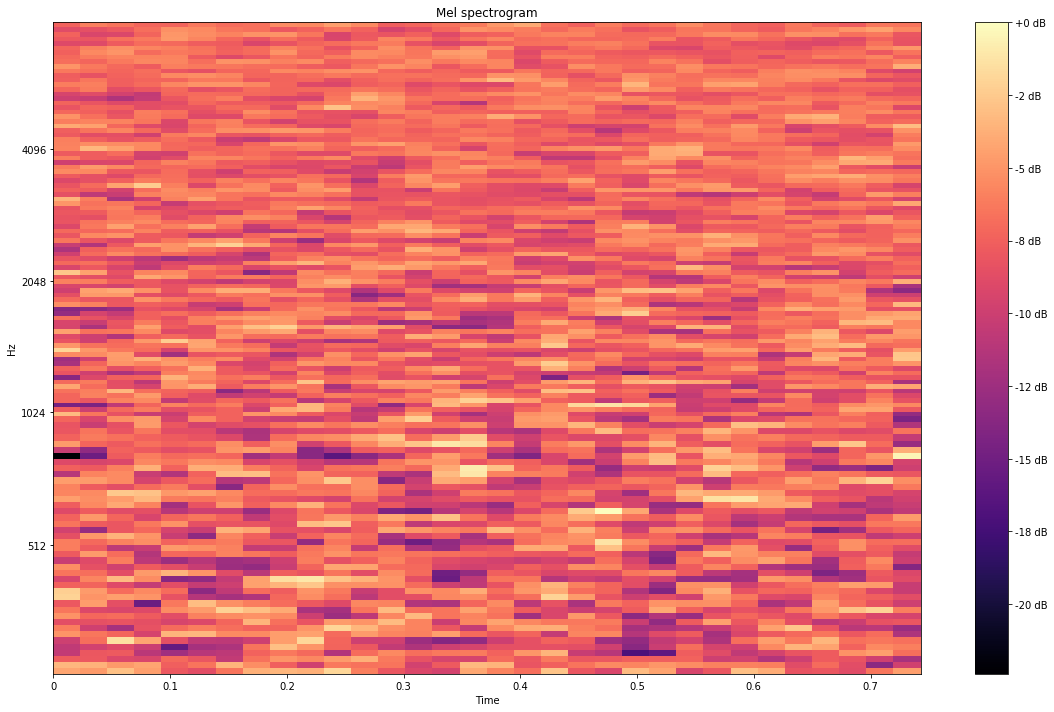

In [39]:
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [40]:
S.shape

(128, 32)

In [36]:
np.max()

TypeError: amax() missing 1 required positional argument: 'a'

In [61]:
[np.random.randint(10)]*3

[4, 4, 4]

In [67]:
S.shape

(128, 32)

In [76]:
librosa.feature.mfcc(y=wav, sr=config.SAMPLE_RATE).shape

(20, 32)

In [78]:
Res = pd.read_csv("model/VGG1Dv2/2018_01_09_02_15_56/valid_probs.csv")

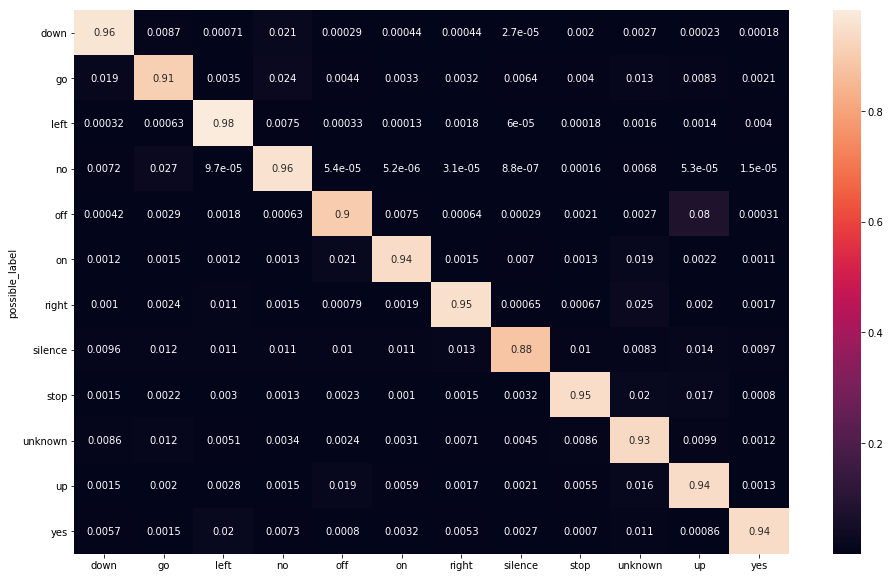

In [85]:
sns.heatmap(Res.groupby("possible_label")[sorted(config.POSSIBLE_LABELS)].mean(), annot=True)

In [108]:
Res["max_probs"] = Res[config.POSSIBLE_LABELS].max(1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f991d72e8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f991dc1fd68>]], dtype=object)

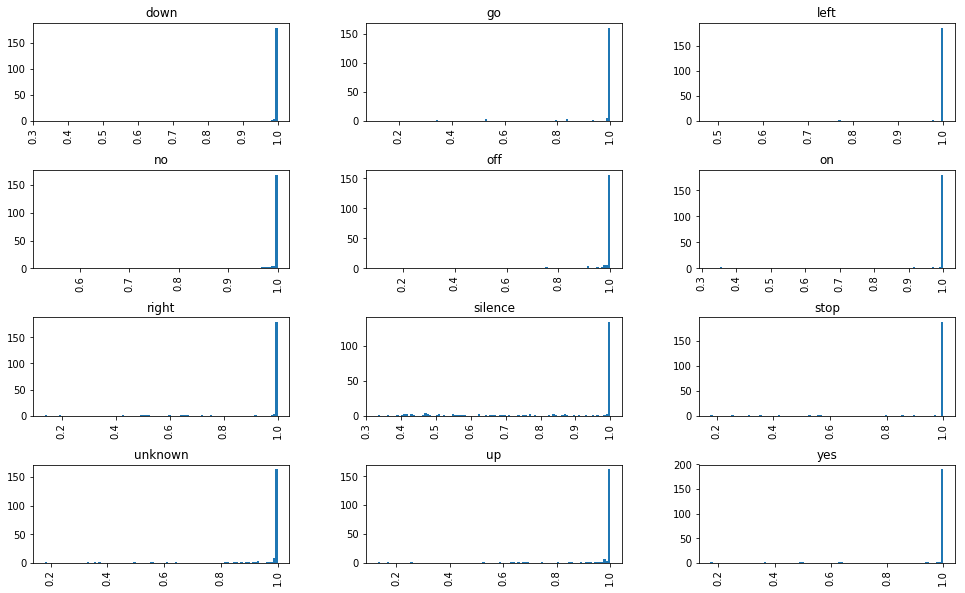

In [110]:
Res.max_probs.hist(by=Res.possible_label, bins=100)

In [100]:
def highpass_filter(samples, cutoff,                                                 
                   sample_rate=config.SAMPLE_RATE,                            
                   numtaps=255):                                                        
    nyq_freq = sample_rate/2                                                    
    cutoff_normalized = cutoff/nyq_freq                                  
    fir_filter = signal.firwin(numtaps, cutoff_normalized, pass_zero=False)        
    filterred_samples = signal.lfilter(fir_filter, 1, samples)       
    return filterred_samples

In [105]:
for row in Res[Res.possible_label == "off"][["path", "up"]].sort_values(by="up", ascending=False).head(10).values:
    print(row[0], row[1])
    sr, wav = wavfile.read(row[0])
    IPD.display(IPD.Audio(wav, rate=sr))
    IPD.display(IPD.Audio(highpass_filter(wav, 880), rate=sr))

input/train/audio/off/c6ee87a7_nohash_3.wav 0.9999340772628784


input/train/audio/off/c6ee87a7_nohash_0.wav 0.9998533725738524


input/train/audio/off/b6ebe225_nohash_0.wav 0.9994148015975952


input/train/audio/off/c50225fa_nohash_2.wav 0.9968854784965516


input/train/audio/off/dbb40d24_nohash_1.wav 0.9800208210945128


input/train/audio/off/5fadb538_nohash_0.wav 0.9722541570663452


input/train/audio/off/cc6bae0d_nohash_0.wav 0.9154860973358154


input/train/audio/off/f9ebdba0_nohash_0.wav 0.900160551071167


input/train/audio/off/c842b5e4_nohash_0.wav 0.8512165546417236


input/train/audio/off/41285056_nohash_1.wav 0.8133989572525024


In [661]:
mat_probs1 = pd.read_csv("result/probs/material/VGG1Dv2_pseudo_oversampling_stftcnn.csv")
mat_probs2 = pd.read_csv("result/probs/material/VGG1Dv2_normal.csv")

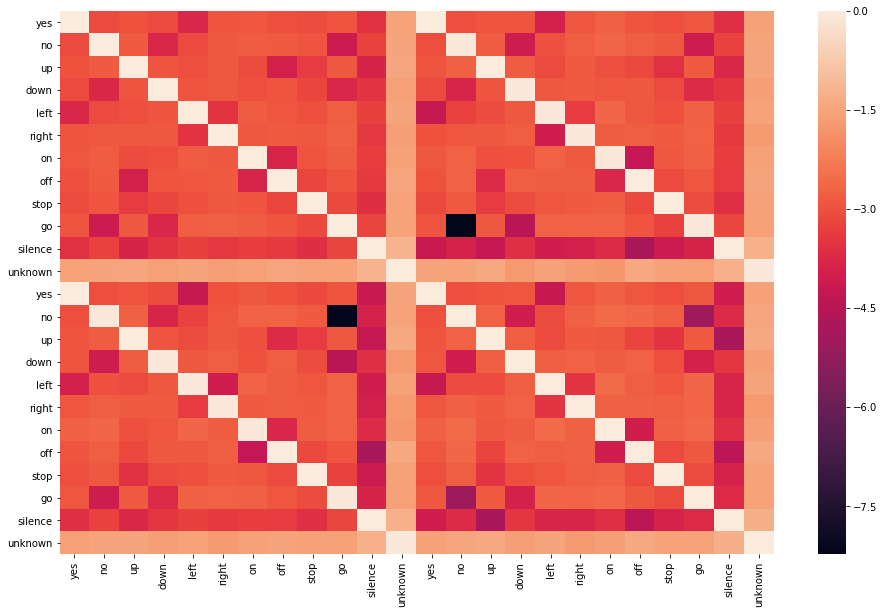

In [664]:
sns.heatmap(np.log(np.abs(pd.concat([mat_probs1, mat_probs2], axis=1).corr())))

In [673]:
def tf_wave_to_mfcc(fname):

    sr, wave = wavfile.read(fname)
    spectrogram = librosa.feature.melspectrogram(wave, sr=config.SAMPLE_RATE, n_mels=40, hop_length=160, n_fft=480, fmin=20, fmax=4000)
    #spectrogram = librosa.power_to_db(spectrogram)
    idx = [spectrogram > 0]
    spectrogram[idx] = np.log(spectrogram[idx])

    dct_filters = librosa.filters.dct(n_filters=40, n_input=40)
    mfcc = [np.matmul(dct_filters, x) for x in np.split(spectrogram, spectrogram.shape[1], axis=1)]
    mfcc = np.hstack(mfcc)
    mfcc = mfcc.astype(np.float32)

    return mfcc

In [735]:
x = tf_wave_to_mfcc('input/test/audio/' + sub_probs.fname[0])
x.shape

(40, 101)

In [730]:
def librosa_wave_to_mfcc(fname):
    sr, wave = wavfile.read(fname)
    return signal.stft(wave)

In [731]:
%timeit librosa_wave_to_mfcc('input/test/audio/' + sub_probs.fname[0])

1.04 ms ± 388 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [682]:
materials = {}
for path in Path("result/probs/material/").glob("*.csv"):
    m = pd.read_csv(path)
    m["label"] = m[config.POSSIBLE_LABELS].idxmax(1)
    materials[str(path)] = m

In [684]:
for p, df in materials.items():
    print(p)
    print(df.label.value_counts())

result/probs/material/VGG1Dv2_offline.csv
unknown    72651
silence    15642
go          8650
on          7887
no          7830
left        7065
off         6992
right       6886
up          6670
down        6297
stop        6209
yes         5759
Name: label, dtype: int64
result/probs/material/VGG1Dv2_normal.csv
unknown    74063
silence    15882
no          8021
on          7698
left        7598
go          7205
off         6900
stop        6417
up          6416
right       6359
down        6205
yes         5774
Name: label, dtype: int64
result/probs/material/VGG1Dv2_pseudo_oversampling_stftcnn.csv
unknown    80246
silence    16122
go          6812
no          6699
left        6610
on          6402
right       6322
off         6282
up          6244
stop        5756
yes         5746
down        5297
Name: label, dtype: int64
result/probs/material/STFTCNNv2_oversampling.csv
unknown    81928
silence    13386
left        6846
on          6761
off         6736
no          6544
go          62